# Experimentation with new buffer structure

In [23]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy

import torch
import torchvision

n_epochs = 3
batch_size = 32
val_batch_size = 512
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1

torch.manual_seed(random_seed)

# MNIST
# train_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.MNIST('data/', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
#                              ])),
#   batch_size=batch_size, shuffle=True, drop_last=True)

# test_loader = torch.utils.data.DataLoader(
#   torchvision.datasets.MNIST('data/', train=False, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
#                              ])),
# FASHION MNIST
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                                    transform=torchvision.transforms.Compose([
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                    ])),
    batch_size=batch_size, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                                    transform=torchvision.transforms.Compose([
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                    ])),
  



  batch_size=val_batch_size, shuffle=True, drop_last=True)


In [17]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

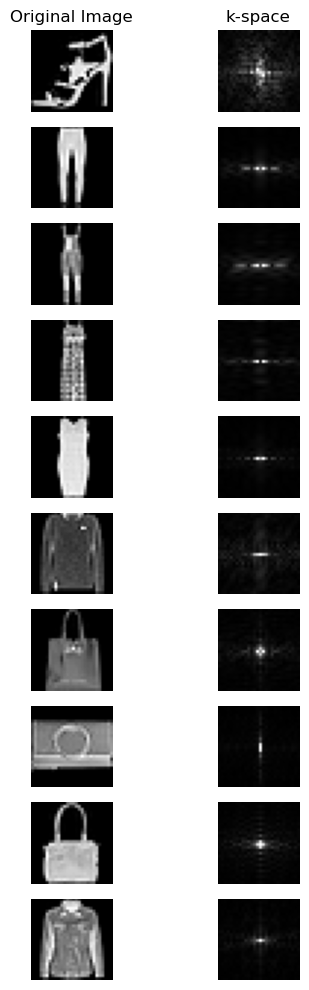

In [18]:

n = 10

fig, axs = plt.subplots(n, 2, figsize=(5, 10))
for i in range(n):
    axs[i, 0].imshow(example_data[i, 0, :, :], cmap='gray')
    # take the fourier transform of the image
    data_fft = np.fft.fft2(example_data[i, 0, :, :])
    # Shift the zero-frequency component to the center of the spectrum.
    data_fft = np.fft.fftshift(data_fft)
    axs[i, 1].imshow(np.abs(data_fft), cmap='gray')
    
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

axs[0, 0].set_title('Original Image')
axs[0, 1].set_title('k-space')

fig.tight_layout()

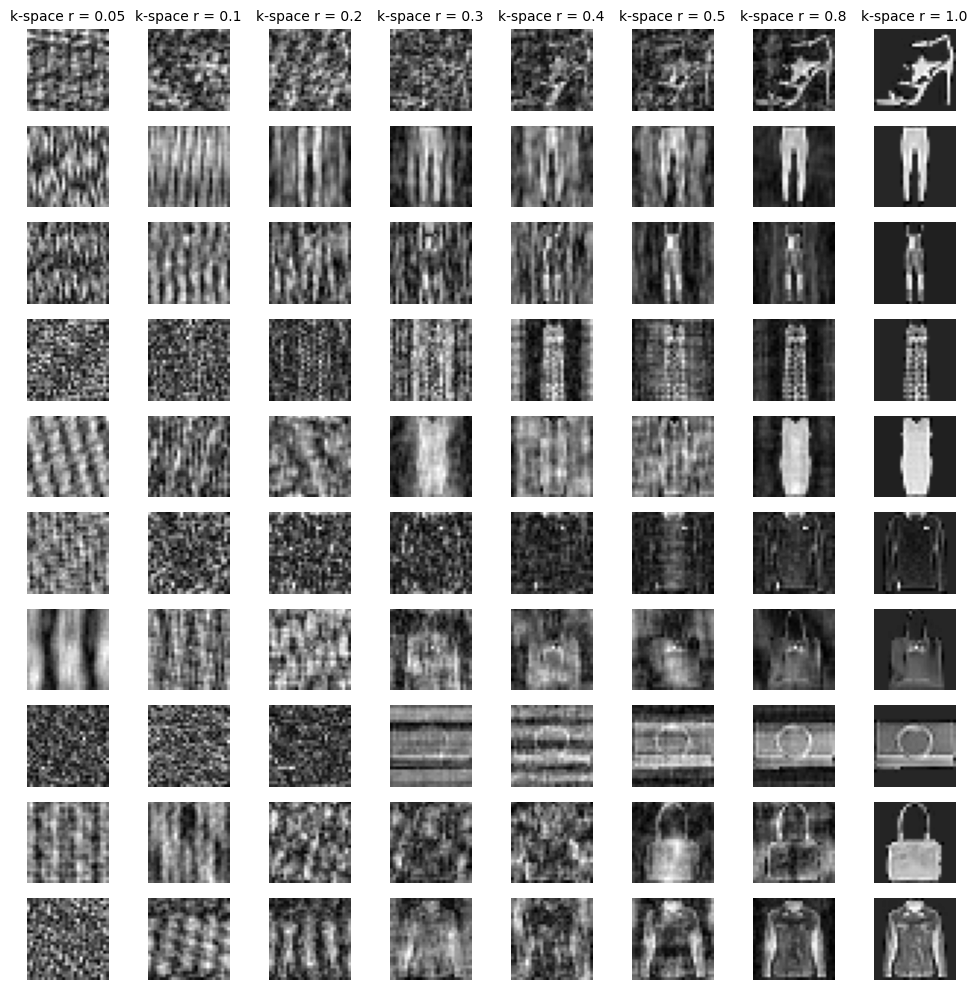

In [19]:
# For each example image, vsualize the inverse ksapce transform for a subset of the k-space data
k_space_ratios = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
n = 10

fig, axs = plt.subplots(n, len(k_space_ratios), figsize=(10, 10))

for i in range(n):
    # take the fourier transform of the image
    data_fft = np.fft.fft2(example_data[i, 0, :, :])
    # Shift the zero-frequency component to the center of the spectrum.
    data_fft = np.fft.fftshift(data_fft)
    
    for j, k_space_ratio in enumerate(k_space_ratios):
        # zero out the k-space data
        data_fft_r = data_fft.copy().flatten()
        zero_indices = np.random.choice(np.arange(len(data_fft_r)), size=int(len(data_fft_r) * (1 - k_space_ratio)), replace=False)
        data_fft_r[zero_indices] = 0  
        data_fft_r = data_fft_r.reshape(data_fft.shape)      
    
        # inverse fourier transform
        data_ifft = np.fft.ifft2(data_fft_r)
        axs[i, j].imshow(np.abs(data_ifft), cmap='gray')
        axs[i, j].axis('off')
        
        if i == 0:
            axs[i, j].set_title(f'k-space r = {k_space_ratio}', fontsize=10)
            
fig.tight_layout()
            

In [88]:
class ConvBlock(torch.nn.Module):
    """
    A convolutional block that takes a feature map and outputs a feature map
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, max_pool=False):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = torch.nn.ReLU()
        self.batch_norm = torch.nn.BatchNorm2d(out_channels)
        self.max_pool = max_pool
        if max_pool:
            self.max_pool = torch.nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.relu(self.batch_norm(self.conv(x)))
        if self.max_pool:
            x = self.max_pool(x)
        return x
    
class TransposedConvBlock(torch.nn.Module):
    """
    A transposed convolutional block that takes a feature map and outputs a feature map
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        super(TransposedConvBlock, self).__init__()
        self.conv = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)
        self.relu = torch.nn.ReLU()
        self.batch_norm = torch.nn.BatchNorm2d(out_channels)
    def forward(self, x):
        return self.relu(self.batch_norm(self.conv(x)))
        
class PBlock(torch.nn.Module):
    """
    A  single layer perceptron that takes a feature map and outputs a feature map
    """
    def __init__(self, in_channels, out_channels):
        super(PBlock, self).__init__()
        self.fc = torch.nn.Linear(in_channels, out_channels)
        self.relu = torch.nn.ReLU()
        self.batch_norm = torch.nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        return self.relu(self.batch_norm(self.fc(x)))
        

class Q_classifier(torch.nn.Module):
    """
    A naural network that takes in a 28x28 image and has two outputs,
    One output is the softmax classification of the image
    The other output is k-space postion to sample logits on a grid 
    """
    def __init__(self, in_channels, dims, class_dims, k_space_dims, out_classes, out_k_space_shape):
        
        super(Q_classifier, self).__init__()
        
        assert len(dims) == 3, 'dims must be a list of length 3'

        dims = [in_channels] + dims
        
        self.class_conv_blocks = torch.nn.Sequential()
        for i in range(len(dims) - 1):
            self.class_conv_blocks.add_module(f'conv_block_{i}', ConvBlock(dims[i], dims[i+1], 3, 1, 1, max_pool=True))
            
        self.k_space_conv_blocks = torch.nn.Sequential()
        for i in range(len(dims) - 1):
            self.k_space_conv_blocks.add_module(f'conv_block_{i}', ConvBlock(dims[i], dims[i+1], 3, 1, 1, max_pool=True))
                        
        self.classifier = torch.nn.Sequential()
        class_dims = [dims[-1] * 3 * 3] + class_dims
        
        for i in range(len(class_dims) - 1):
            self.classifier.add_module(f'p_block_{i}', PBlock(class_dims[i], class_dims[i+1]))
        self.classifier.add_module(f'p_block_{i+1}', torch.nn.Linear(class_dims[-1], out_classes))
        
        self.k_space = torch.nn.Sequential()
        k_space_dims = [dims[-1] * 3 * 3] + k_space_dims
        for i in range(len(k_space_dims) - 1):
            self.k_space.add_module(f'p_block_{i}', PBlock(k_space_dims[i], k_space_dims[i+1]))
        self.out_k_space_shape = out_k_space_shape
        self.k_space.add_module(f'p_block_{i+1}', torch.nn.Linear(k_space_dims[-1], 32*np.prod(out_k_space_shape)))

        
        self.mix_k_space_blocks = torch.nn.Sequential()
        mix_dims = [32, 32]
        for i in range(len(mix_dims) - 1):
            self.mix_k_space_blocks.add_module(f'p_block_{i}', ConvBlock(mix_dims[i], mix_dims[i+1], 3, 1, 1, max_pool=False))
            
        self.mix_k_space_blocks.add_module(f'p_block_{i}', torch.nn.Conv2d(in_channels=mix_dims[-1], out_channels=1, kernel_size=1, stride=1, padding=0))
        
    def forward(self, x, k_space_samples=None):
        x_class = self.class_conv_blocks(x)
        x_class = x_class.view(x_class.shape[0], -1)
        
        
        class_output = self.classifier(x_class)
        x_k_space = None
        if k_space_samples is not None:
            x_k_space = self.k_space_conv_blocks(x).view(x.shape[0], -1)
            #x_k_space = torch.cat([x_k_space, x_class], dim=1)
            x_k_space = self.k_space(x_k_space).view(x_k_space.shape[0], 32, *self.out_k_space_shape)
            x_k_space[:, [0], :, :] = x_k_space[:, [0], :, :] + k_space_samples
            x_k_space = self.mix_k_space_blocks(x_k_space)
            
                
        return class_output, x_k_space
        

In [93]:
# Train a reinforcement learning agent to learn the optimal k-space sampling pattern
device = torch.device('cuda:0')
print(f'Using device: {device}')

dims = [16, 32, 64]
Q = Q_classifier(1, dims, [64, 64], [128, 256, 512], 10, (28, 28))
Q = Q.to(device)

epochs = 10
bank_size = 512

# The number of steps to take in the environment for the agent during validation
t_eval = 32

gamma = 0.9
lr = 0.003

optimizer = torch.optim.Adam(Q.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

loss = torch.nn.CrossEntropyLoss(reduction='none')

# The full k_space
kspace_buffer = torch.zeros(batch_size*bank_size, 1, 28, 28, dtype=torch.complex64).to(device)
# The sampled k_space
kspace_sample_buffer = torch.zeros(batch_size*bank_size, 1, 28, 28).to(device)
# The labels
labels_buffer = torch.zeros(batch_size*bank_size, dtype=torch.long).to(device)
# Load the s_data with the original data
for i, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    kspace_buffer[i * batch_size:(i + 1) * batch_size] = torch.fft.fftshift(torch.fft.fft2(data), dim=(-2, -1))
    # Each sample gets a random number of samples
    n_samples = np.random.randint(1, 28*2, size=batch_size)
    for j in range(batch_size):
        # Sample the k-space
        sample = np.random.choice(28*28, size=n_samples[j], replace=False)
        kspace_sample_buffer[i * batch_size + j, 0, sample // 28, sample % 28] = 1
        
    labels_buffer[i * batch_size:(i + 1) * batch_size] = target
    if i == bank_size - 1:
        break

loss_fnc = torch.nn.CrossEntropyLoss(reduction='none')

epsilon_trheshold = 0.1
epsilon_scaler = 1.0

bank_iter = 0

# Train the reinforcement learning agent
train_batch_size = 512

for epoch in range(epochs):
    Q.train()
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Sample a random subset of the bank as the current batch
        batch_idx = np.random.choice(bank_size*batch_size, size=train_batch_size, replace=False)
        ksapce_batch = kspace_buffer[batch_idx]
        kspace_sample_batch = kspace_sample_buffer[batch_idx]
        labels_batch = labels_buffer[batch_idx]
        
        # Sample the k-space
        kspace_sampled_batch = ksapce_batch.clone()
        kspace_sampled_batch[kspace_sample_batch == 0] = 0
        
        # Do inverse fourier transform
        data_transformed = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(kspace_sampled_batch, dim=(-2, -1))))
                
        # Get the action
        _, action = Q(data_transformed, kspace_sample_batch)
        action = action.view(action.shape[0], -1)
        action_tmp = action.clone().detach()
        
        # Do not select actions that have already been selected
        action_tmp[kspace_sample_batch.view(kspace_sample_batch.shape[0], -1) == 1] = -1e10
        argmax_action = action_tmp.argmax(dim=1)
        
        # Whith a probability of 0.1, sample a random action
        random_action = np.random.choice(28*28, size=train_batch_size)
        random_action = torch.tensor(random_action, dtype=torch.long).to(device)
        epsilon = np.random.rand(train_batch_size)
        argmax_action[epsilon < epsilon_trheshold] = random_action[epsilon < epsilon_trheshold]
        
        # Sample the k-space again
        kspace_sample_batch[torch.arange(kspace_sample_batch.shape[0]), 0, argmax_action // 28, argmax_action % 28] = 1
        # Update buffer
        kspace_sample_buffer[batch_idx] = kspace_sample_batch
        
        kspace_sampled_batch = ksapce_batch.clone()
        kspace_sampled_batch[kspace_sample_batch == 0] = 0
        
        # Do inverse fourier transform
        data_transformed = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(kspace_sampled_batch, dim=(-2, -1)))) 
        
        # Get the prediction
        pred, action_m = Q(data_transformed, kspace_sample_batch)
        action_m = action_m.view(action.shape[0], -1)
        max_action_m = action_m.max(dim=1)[0].detach()
        
        bp_action = action[torch.arange(action.shape[0]), argmax_action]
        
        # Calculate the loss
        class_loss = loss_fnc(pred, labels_batch.long())
        rl_loss = (-class_loss.detach() + gamma * max_action_m - bp_action)**2
        loss = 0.1*rl_loss.mean() + class_loss.mean()
        loss.backward()
        
        optimizer.step()
        
        # Cycle the buffers
        kspace_data = torch.fft.fftshift(torch.fft.fft2(data), dim=(-2, -1))
        start_idx = (bank_iter * batch_size) % (bank_size * batch_size)
        end_idx = start_idx + batch_size
        kspace_buffer[start_idx:end_idx] = kspace_data
        kspace_sample_buffer[start_idx:end_idx] = 0
        labels_buffer[start_idx:end_idx] = target
        
        bank_iter += 1
        
        if i % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}, Class loss: {class_loss.mean().item()}')
        
    # Evaluate the model
    Q.eval()
    
    epsilon_trheshold *= epsilon_scaler
    
    accuracies = np.zeros(t_eval)
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            val_kspace = torch.fft.fftshift(torch.fft.fft2(data), dim=(-2, -1))
            val_kspace_sample = torch.zeros(val_batch_size, 1, 28, 28).to(device)
            val_labels = target
            
            for step in range(t_eval):
                # Sample the k-space
                kspace_sample = val_kspace.clone()
                kspace_sample[val_kspace_sample == 0] = 0
                
                # Do inverse fourier transform
                data_transformed = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(kspace_sample, dim=(-2, -1))))
                
                # Get the action and allways use the argmax action
                pred, action = Q(data_transformed, val_kspace_sample)
                
                action = action.view(action.shape[0], -1)
                # Make sure the action is not already sampled
                action[val_kspace_sample.view(val_kspace_sample.shape[0], -1) == 1] = -1e10
                argmax_action = action.argmax(dim=1)
                
                # Sample the k-space again
                val_kspace_sample[torch.arange(val_kspace_sample.shape[0]), 0, argmax_action // 28, argmax_action % 28] = 1
                
                # Calculate the accuracy
                pred = pred.argmax(dim=1, keepdim=True)
                accuracies[step] += pred.eq(val_labels.view_as(pred)).sum().item()

    accuracies /= len(test_loader.dataset)
    print(f"Epoch: {epoch}, Accuracy: {accuracies}")


Using device: cuda:0


/tmp/ipykernel_12332/4188600405.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kspace_sample_batch[torch.arange(kspace_sample_batch.shape[0]), 0, argmax_action // 28, argmax_action % 28] = 1


Epoch: 0, Batch: 0, Loss: 2.5843167304992676, Class loss: 2.357184410095215
Epoch: 0, Batch: 100, Loss: 2.1844639778137207, Class loss: 1.999750018119812
Epoch: 0, Batch: 200, Loss: 2.1730358600616455, Class loss: 1.9464573860168457
Epoch: 0, Batch: 300, Loss: 2.1939473152160645, Class loss: 1.9618175029754639
Epoch: 0, Batch: 400, Loss: 2.3434224128723145, Class loss: 2.0142178535461426
Epoch: 0, Batch: 500, Loss: 2.6062564849853516, Class loss: 2.1456055641174316
Epoch: 0, Batch: 600, Loss: 2.548854112625122, Class loss: 2.135578155517578
Epoch: 0, Batch: 700, Loss: 2.394435405731201, Class loss: 2.1483280658721924
Epoch: 0, Batch: 800, Loss: 2.474403142929077, Class loss: 2.1187424659729004
Epoch: 0, Batch: 900, Loss: 2.2621471881866455, Class loss: 2.057234764099121
Epoch: 0, Batch: 1000, Loss: 2.263127326965332, Class loss: 2.0544795989990234
Epoch: 0, Batch: 1100, Loss: 2.2636590003967285, Class loss: 2.0887770652770996
Epoch: 0, Batch: 1200, Loss: 2.251520872116089, Class loss: 

/tmp/ipykernel_12332/4188600405.py:156: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  val_kspace_sample[torch.arange(val_kspace_sample.shape[0]), 0, argmax_action // 28, argmax_action % 28] = 1


Epoch: 0, Accuracy: [0.0976 0.2099 0.2251 0.2377 0.2406 0.2541 0.2598 0.2622 0.283  0.2746
 0.3087 0.3147 0.3187 0.3274 0.3323 0.3394 0.3441 0.344  0.3479 0.3486
 0.3508 0.3489 0.3463 0.348  0.351  0.3601 0.3671 0.3724 0.3778 0.3821
 0.385  0.3894]
Epoch: 1, Batch: 0, Loss: 1.8032726049423218, Class loss: 1.6603305339813232
Epoch: 1, Batch: 100, Loss: 1.4749767780303955, Class loss: 1.3561283349990845
Epoch: 1, Batch: 200, Loss: 1.3655033111572266, Class loss: 1.275244951248169
Epoch: 1, Batch: 300, Loss: 1.3822592496871948, Class loss: 1.2897846698760986
Epoch: 1, Batch: 400, Loss: 1.4409619569778442, Class loss: 1.3529270887374878
Epoch: 1, Batch: 500, Loss: 1.3827052116394043, Class loss: 1.3054230213165283
Epoch: 1, Batch: 600, Loss: 1.3998963832855225, Class loss: 1.308861494064331
Epoch: 1, Batch: 700, Loss: 1.3342374563217163, Class loss: 1.2439854145050049
Epoch: 1, Batch: 800, Loss: 1.2916513681411743, Class loss: 1.2153162956237793
Epoch: 1, Batch: 900, Loss: 1.33737075328826

KeyboardInterrupt: 

In [ ]:
# Save the weights
torch.save(Q.state_dict(), 'q_network_fashion.pt')

/tmp/ipykernel_12332/2006356727.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  val_kspace_sample[torch.arange(val_kspace_sample.shape[0]), 0, argmax_action // 28, argmax_action % 28] = 1


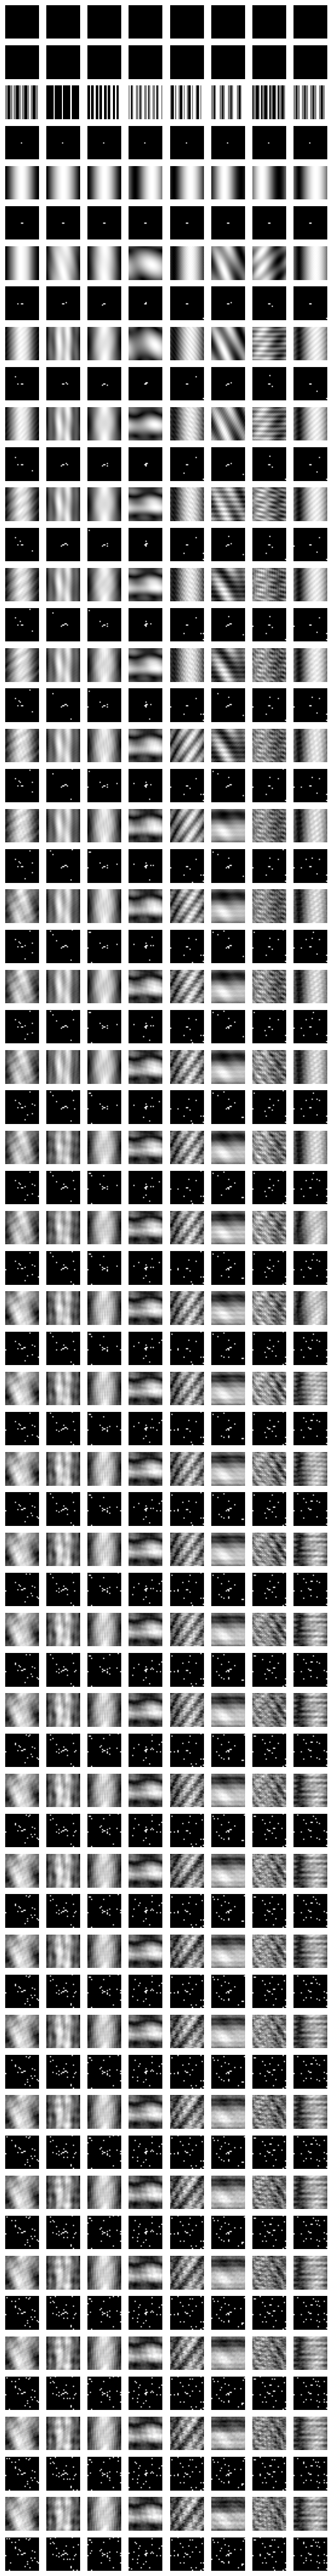

In [94]:
# Evaluate the model
Q.eval()

accuracies = np.zeros(t_eval)

avg_k_space = torch.zeros(10, 1, 28, 28).to(device)
n_samples = torch.zeros(10).to(device)


for i, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    val_kspace = torch.fft.fftshift(torch.fft.fft2(data), dim=(-2, -1))
    val_kspace_sample = torch.zeros(val_batch_size, 1, 28, 28).to(device)
    val_labels = target
    
    if i == 0:
        n_show = 8
        fig, axs = plt.subplots(2*t_eval, n_show, figsize=(n_show, 2*t_eval)) 
        
    for step in range(t_eval):
        # Sample the k-space
        kspace_sample = val_kspace.clone()
        kspace_sample[val_kspace_sample == 0] = 0
        
        # Do inverse fourier transform
        data_transformed = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(kspace_sample, dim=(-2, -1))))
        
        # Get the action and allways use the argmax action
        pred, action = Q(data_transformed, val_kspace_sample)

        if i == 0:
            for j in range(n_show):
                image = data_transformed[j, 0].cpu().numpy()
                axs[step*2, j].imshow(image, cmap='gray')
                axs[step*2, j].axis('off')
                axs[step*2+1, j].imshow(val_kspace_sample[j, 0].cpu().numpy(), cmap='gray')
                axs[step*2+1, j].axis('off')
                
        action = action.view(action.shape[0], -1)
        # Make sure the action is not already sampled
        action[val_kspace_sample.view(val_kspace_sample.shape[0], -1) == 1] = -1e10
        argmax_action = action.argmax(dim=1)
                    
        # Sample the k-space again
        val_kspace_sample[torch.arange(val_kspace_sample.shape[0]), 0, argmax_action // 28, argmax_action % 28] = 1
    
        # Do inverse fourier transform
        kspace_sample = val_kspace.clone()
        kspace_sample[val_kspace_sample == 0] = 0
        
        # Calculate the accuracy
        pred = pred.argmax(dim=1, keepdim=True)
        accuracies[step] += pred.eq(val_labels.view_as(pred)).sum().item()
        
        # Calculate the average k-space
        if step == t_eval - 1:
            for j in range(10):
                avg_k_space[j] += val_kspace_sample[pred == j].sum(dim=0)
                n_samples[j] += (pred == j).sum()
            
accuracies /= len(test_loader.dataset)


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


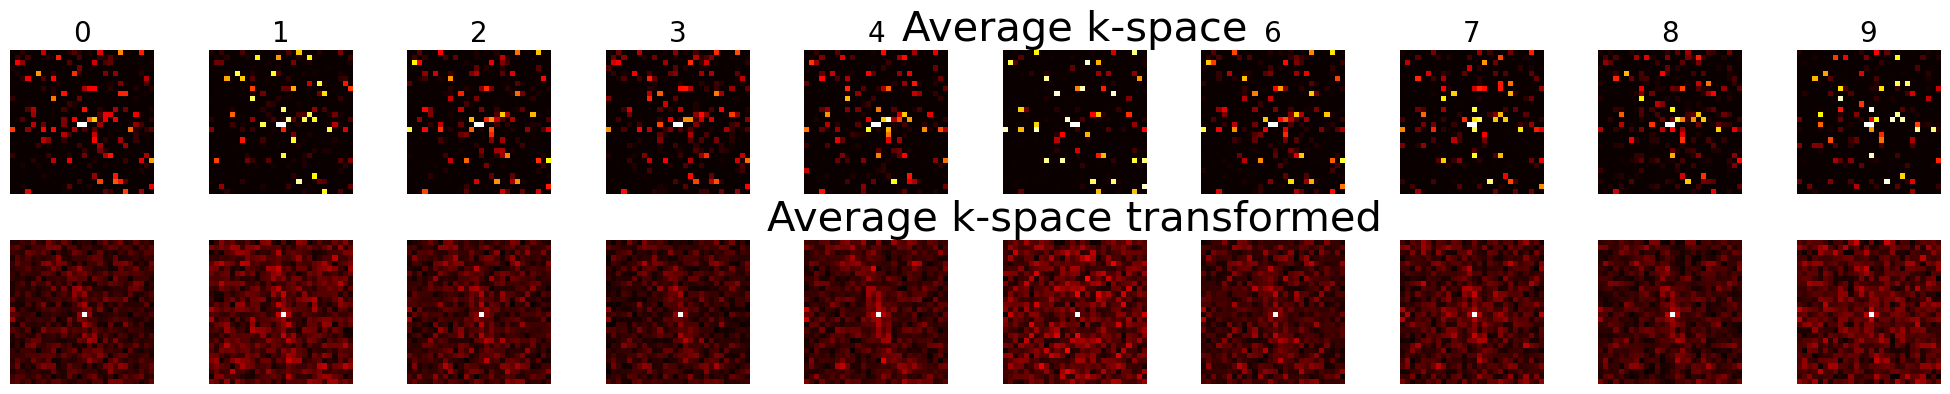

In [95]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(avg_k_space[i, 0].cpu().numpy(), cmap='hot')
    fft_transformed = torch.fft.fftshift(torch.fft.fft2(avg_k_space[i]))
    print(fft_transformed.shape)
    fft_transformed = torch.abs(fft_transformed)
    axs[1, i].imshow(fft_transformed[0].cpu().numpy(), cmap='hot')
    
for ax in axs.flatten():
    ax.axis('off')
    
# Add titles under each column indicating the digit
for i in range(10):
    axs[0, i].set_title(f'{i}', fontsize=20)
    
axs[0, 5].set_title('Average k-space', fontsize=30)
axs[1, 5].set_title('Average k-space transformed', fontsize=30)
    
fig.tight_layout()

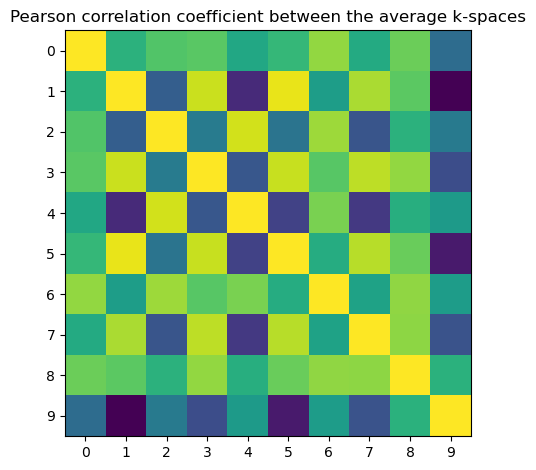

In [72]:
# Calculate Pearson correlation coefficient between the average k-spaces
avg_k_space_flat = avg_k_space.view(avg_k_space.shape[0], -1)
avg_k_space_flat = avg_k_space_flat.detach().cpu().numpy()
import scipy.stats
corrs = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        corrs[i, j] = np.abs(scipy.stats.pearsonr(avg_k_space_flat[i], avg_k_space_flat[j])[0]) 

fig, ax = plt.subplots()
ax.imshow(corrs)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_title('Pearson correlation coefficient between the average k-spaces')
fig.tight_layout()

In [ ]:
def circle_sample(N, M):
    canvas = np.zeros((N, N))

    dir = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])
    steps_to_edge = 1
    steps_count = -1
    dir_index = 0

    pos = np.array([N // 2-1, N // 2-2])

    for i in range(M):
        if steps_count == steps_to_edge:
            steps_count = 0
            dir_index = (dir_index + 1) % 4
            if dir_index % 2 == 0:
                steps_to_edge += 1
        pos += dir[dir_index]
        canvas[pos[0], pos[1]] = 1
        steps_count += 1
    return torch.from_numpy(canvas).float()

In [ ]:
# Precompute the circle sample

circle_samples = torch.zeros(28*28, 1, 28, 28).to(device)
for i in range(28*28):
    circle_samples[i, 0] = circle_sample(28, i+1)

circle_samples = circle_samples.to(device)

In [ ]:
# Train a deep learning model with circular k-space sampling
device = torch.device('cuda:0')
print(f'Using device: {device}')

epochs = 1
lr = 1e-3
dims = [16, 32, 64]
Classifier = Q_classifier(1, dims, [64, 64], [128, 128], 10, (28, 28))
Classifier = Classifier.to(device)

epochs = 10
bank_size = 32

# The number of steps to take in the environment for the agent during validation
t_eval = 32

gamma = 0.5
lr = 2e-5

optimizer = torch.optim.Adam(Classifier.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

loss = torch.nn.CrossEntropyLoss()


# The full k_space
s_kspace = torch.zeros(batch_size*bank_size, 1, 28, 28, dtype=torch.complex64).to(device)
# The sampled k_space
kspace_sample_buffer = torch.zeros(batch_size*bank_size, 1, 28, 28).to(device)
# The labels
s_labels = torch.zeros(batch_size*bank_size, dtype=torch.long).to(device)
s_nsamples = torch.zeros(batch_size*bank_size, dtype=torch.long).to(device)
# Load the s_data with the original data
for i, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    s_kspace[i * batch_size:(i + 1) * batch_size] = torch.fft.fftshift(torch.fft.fft2(data), dim=(-2, -1))
    # Each sample gets a random number of samples
    n_samples = np.random.randint(1, 28*2, size=batch_size)
    for j in range(batch_size):
        # Sample the k-space
        kspace_sample_buffer[i * batch_size + j] = circle_sample(28, n_samples[j])
        s_nsamples[i * batch_size + j] = n_samples[j]
        
    s_labels[i * batch_size:(i + 1) * batch_size] = target
    if i == bank_size - 1:
        break


# Train the reinforcement learning agent
for epoch in range(epochs):
    Classifier.train()
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Switch out a random subset of the samples in the bank
        batch_idx = np.random.choice(bank_size*batch_size, size=batch_size, replace=False)
        s_kspace[batch_idx] = torch.fft.fftshift(torch.fft.fft2(data.to(device)), dim=(-2, -1))
        s_nsamples[batch_idx] = 1
        #s_kspace_sample[switcg_idx] = circle_sample(28, 1)  
        for j in range(bank_size*batch_size):
            kspace_sample_buffer[j] = circle_samples[s_nsamples[j]]
        s_labels[batch_idx] = target.to(device)
        s_nsamples += 1
        
        # Sample the k-space
        kspace_sample = s_kspace.clone()
        kspace_sample[kspace_sample_buffer == 0] = 0
        
        # Do inverse fourier transform
        data_transformed = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(kspace_sample, dim=(-2, -1))))
        
        # Get predictions from the model
        pred, _ = Classifier(data_transformed)
            
        # Calculate the loss
        class_loss = loss_fnc(pred, s_labels.long())
        loss = class_loss.mean()
        loss.backward()
        
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {i},Class loss: {class_loss.mean().item()}')
        
    # Evaluate the model
    Classifier.eval()
    
    class_accuracies = np.zeros(t_eval)
    
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        val_kspace = torch.fft.fftshift(torch.fft.fft2(data), dim=(-2, -1))
        
        
        val_labels = target
        
        for step in range(t_eval):
            # Sample the k-space
            val_kspace_sample = circle_sample(28, step+1)[None, None, :, :].to(device)
            val_kspace_sample = val_kspace_sample.repeat(batch_size, 1, 1, 1)
            kspace_sample = val_kspace.clone()
            kspace_sample[val_kspace_sample == 0] = 0

            
            # Do inverse fourier transform
            data_transformed = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(kspace_sample, dim=(-2, -1))))
            
            # Get the action and allways use the argmax action
            pred, _ = Classifier(data_transformed)
            
            # Calculate the accuracy
            pred = pred.argmax(dim=1, keepdim=True)
            class_accuracies[step] += pred.eq(val_labels.view_as(pred)).sum().item()

    class_accuracies /= len(test_loader.dataset)
    print(f"Epoch: {epoch}, Accuracy: {class_accuracies}")



Using device: cuda:0
Epoch: 0, Batch: 0,Class loss: 2.3964529037475586
Epoch: 0, Batch: 100,Class loss: 1.7640482187271118
Epoch: 0, Batch: 200,Class loss: 1.5185719728469849
Epoch: 0, Accuracy: [0.0998 0.1227 0.2211 0.4233 0.4868 0.5025 0.5078 0.5055 0.5104 0.5131
 0.547  0.6245 0.6393 0.6592 0.6658 0.6741 0.6734 0.6777 0.6839 0.6847
 0.6849 0.6861 0.6864 0.6897 0.691  0.6908 0.691  0.6919 0.6918 0.6968
 0.6994 0.7003]
Epoch: 1, Batch: 0,Class loss: 1.4619932174682617


KeyboardInterrupt: 

In [ ]:
# Train a deep learning model with random k-space sampling
device = torch.device('cuda:0')
print(f'Using device: {device}')

epochs = 1
lr = 1e-3
dims = [16, 32, 64]
Classifier = Q_classifier(1, dims, [64, 64], [128, 128], 10, (28, 28))
Classifier = Classifier.to(device)

epochs = 10
bank_size = 32

# The number of steps to take in the environment for the agent during validation
t_eval = 32

gamma = 0.5
lr = 2e-5

optimizer = torch.optim.Adam(Classifier.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

loss = torch.nn.CrossEntropyLoss()


# The full k_space
s_kspace = torch.zeros(batch_size*bank_size, 1, 28, 28, dtype=torch.complex64).to(device)
# The sampled k_space
kspace_sample_buffer = torch.zeros(batch_size*bank_size, 1, 28, 28).to(device)
# The labels
s_labels = torch.zeros(batch_size*bank_size, dtype=torch.long).to(device)
s_nsamples = torch.zeros(batch_size*bank_size, dtype=torch.long).to(device)
# Load the s_data with the original data
for i, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    s_kspace[i * batch_size:(i + 1) * batch_size] = torch.fft.fftshift(torch.fft.fft2(data), dim=(-2, -1))
    s_labels[i * batch_size:(i + 1) * batch_size] = target
    
    if i == bank_size - 1:
        break


# Train the reinforcement learning agent
for epoch in range(epochs):
    Q.train()
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Switch out a random subset of the samples in the bank
        batch_idx = np.random.choice(bank_size*batch_size, size=batch_size, replace=False)
        s_kspace[batch_idx] = torch.fft.fftshift(torch.fft.fft2(data.to(device)), dim=(-2, -1))
        s_nsamples[batch_idx] = 1

        for j in range(bank_size*batch_size):
            rand_int = np.random.randint(1, 32)
            kspace_sample_buffer[j] = torch.rand(1, 1, 28, 28) < rand_int/28**2
            
        s_labels[batch_idx] = target.to(device)
        s_nsamples += 1
        
        # Sample the k-space
        kspace_sample = s_kspace.clone()
        kspace_sample[kspace_sample_buffer == 0] = 0
        
        # Do inverse fourier transform
        data_transformed = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(kspace_sample, dim=(-2, -1))))
        
        # Get predictions from the model
        pred, _ = Classifier(data_transformed)
            
        # Calculate the loss
        class_loss = loss_fnc(pred, s_labels.long())
        loss = class_loss.mean()
        loss.backward()
        
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {i},Class loss: {class_loss.mean().item()}')
        
    # Evaluate the model
    Classifier.eval()
    
    class_accuracies_random = np.zeros(t_eval)
    
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        val_kspace = torch.fft.fftshift(torch.fft.fft2(data), dim=(-2, -1))
        
        
        val_labels = target
        
        for step in range(t_eval):
            # Sample the k-space
            val_kspace_sample = torch.zeros(batch_size, 1, 28, 28).to(device)
            for j in range(batch_size):
                rand_int = step + 1
                rand_grid = np.random.choice(28**2, size=rand_int, replace=False)
                val_kspace_sample[j, 0, rand_grid // 28, rand_grid % 28] = 1
            kspace_sample = val_kspace.clone()
            kspace_sample[val_kspace_sample == 0] = 0

            
            # Do inverse fourier transform
            data_transformed = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(kspace_sample, dim=(-2, -1))))
            
            # Get the action and allways use the argmax action
            pred, _ = Classifier(data_transformed)
            
            # Calculate the accuracy
            pred = pred.argmax(dim=1, keepdim=True)
            class_accuracies_random[step] += pred.eq(val_labels.view_as(pred)).sum().item()

    class_accuracies_random /= len(test_loader.dataset)
    print(f"Epoch: {epoch}, Accuracy: {class_accuracies_random}")

Using device: cuda:0
Epoch: 0, Batch: 0,Class loss: 2.3752732276916504
Epoch: 0, Batch: 100,Class loss: 2.268244981765747
Epoch: 0, Batch: 200,Class loss: 2.284940719604492
Epoch: 0, Batch: 300,Class loss: 2.2503318786621094
Epoch: 0, Batch: 400,Class loss: 2.229867935180664
Epoch: 0, Batch: 500,Class loss: 2.203181743621826
Epoch: 0, Batch: 600,Class loss: 2.213773488998413
Epoch: 0, Batch: 700,Class loss: 2.188255786895752
Epoch: 0, Batch: 800,Class loss: 2.2054953575134277
Epoch: 0, Batch: 900,Class loss: 2.1907567977905273
Epoch: 0, Batch: 1000,Class loss: 2.189953327178955
Epoch: 0, Batch: 1100,Class loss: 2.174455404281616
Epoch: 0, Batch: 1200,Class loss: 2.165742874145508
Epoch: 0, Batch: 1300,Class loss: 2.1730191707611084
Epoch: 0, Batch: 1400,Class loss: 2.162604331970215
Epoch: 0, Batch: 1500,Class loss: 2.1754512786865234
Epoch: 0, Batch: 1600,Class loss: 2.1777663230895996
Epoch: 0, Batch: 1700,Class loss: 2.147484540939331
Epoch: 0, Batch: 1800,Class loss: 2.175606489181

KeyboardInterrupt: 

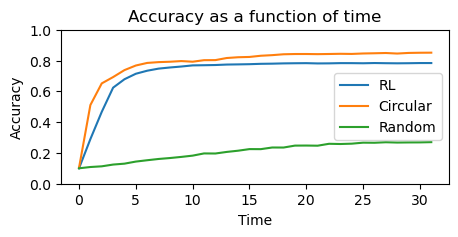

In [ ]:
# Plot accuracy as a function of time
fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(np.arange(t_eval), accuracies, label='RL')
ax.plot(np.arange(t_eval), class_accuracies, label='Circular')
ax.plot(np.arange(t_eval), class_accuracies_random, label='Random')
ax.set_ylim(0, 1)
ax.set_xlabel('Time')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of time')
ax.legend()